In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import joblib
from sklearn.metrics import r2_score
import math

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/computer network/project/network_dataset.csv")

In [ ]:
df.head()

,bw,delay,loss,queue,packet_loss_ratio,rtt,jitter,throughput
0,10,5.393810,2,50,0,13.58,4.847886,10.50
1,10,37.886376,1,50,40,77.70,2.343075,10.50
2,50,10.859811,2,200,0,26.84,10.655187,52.40
3,5,17.059119,5,50,0,41.96,15.799462,5.25
4,50,6.002492,1,50,0,15.12,5.247571,52.40


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 576 entries, 0 to 575
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   bw                 576 non-null    int64  
 1   delay              576 non-null    float64
 2   loss               576 non-null    int64  
 3   queue              576 non-null    int64  
 4   packet_loss_ratio  576 non-null    int64  
 5   rtt                576 non-null    float64
 6   jitter             576 non-null    float64
 7   throughput         576 non-null    float64
dtypes: float64(4), int64(4)
memory usage: 36.1 KB


In [ ]:
df.describe()

,bw,delay,loss,queue,packet_loss_ratio,rtt,jitter,throughput
count,576.000000,576.000000,576.000000,576.000000,576.000000,576.00000,576.000000,576.000000
mean,20.069444,27.428912,1.911458,112.673611,3.437500,100.17408,54.409826,20.985608
std,17.057306,12.706999,1.875464,61.183724,8.256091,64.85772,99.174894,17.822177
min,5.000000,5.070386,0.000000,50.000000,0.000000,13.58000,1.811767,4.990000
25%,5.000000,16.847391,0.000000,50.000000,0.000000,59.43750,21.116404,5.250000
50%,10.000000,28.105781,1.000000,100.000000,0.000000,92.23000,33.556457,10.500000
75%,20.000000,38.691886,2.000000,200.000000,0.000000,123.14000,46.437491,21.000000
max,50.000000,49.976876,5.000000,200.000000,40.000000,742.44000,944.534440,52.400000


In [ ]:
def find_outliers(column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    return df[(df[column] < lower) | (df[column] > upper)]

for col in df.columns:
    outliers = find_outliers(col)
    print(f"\n🔍 {col} sütununda aykırı değer sayısı: {len(outliers)}")


🔍 bw sütununda aykırı değer sayısı: 130

🔍 delay sütununda aykırı değer sayısı: 0

🔍 loss sütununda aykırı değer sayısı: 0

🔍 queue sütununda aykırı değer sayısı: 0

🔍 packet_loss_ratio sütununda aykırı değer sayısı: 91

🔍 rtt sütununda aykırı değer sayısı: 26

🔍 jitter sütununda aykırı değer sayısı: 32

🔍 throughput sütununda aykırı değer sayısı: 130


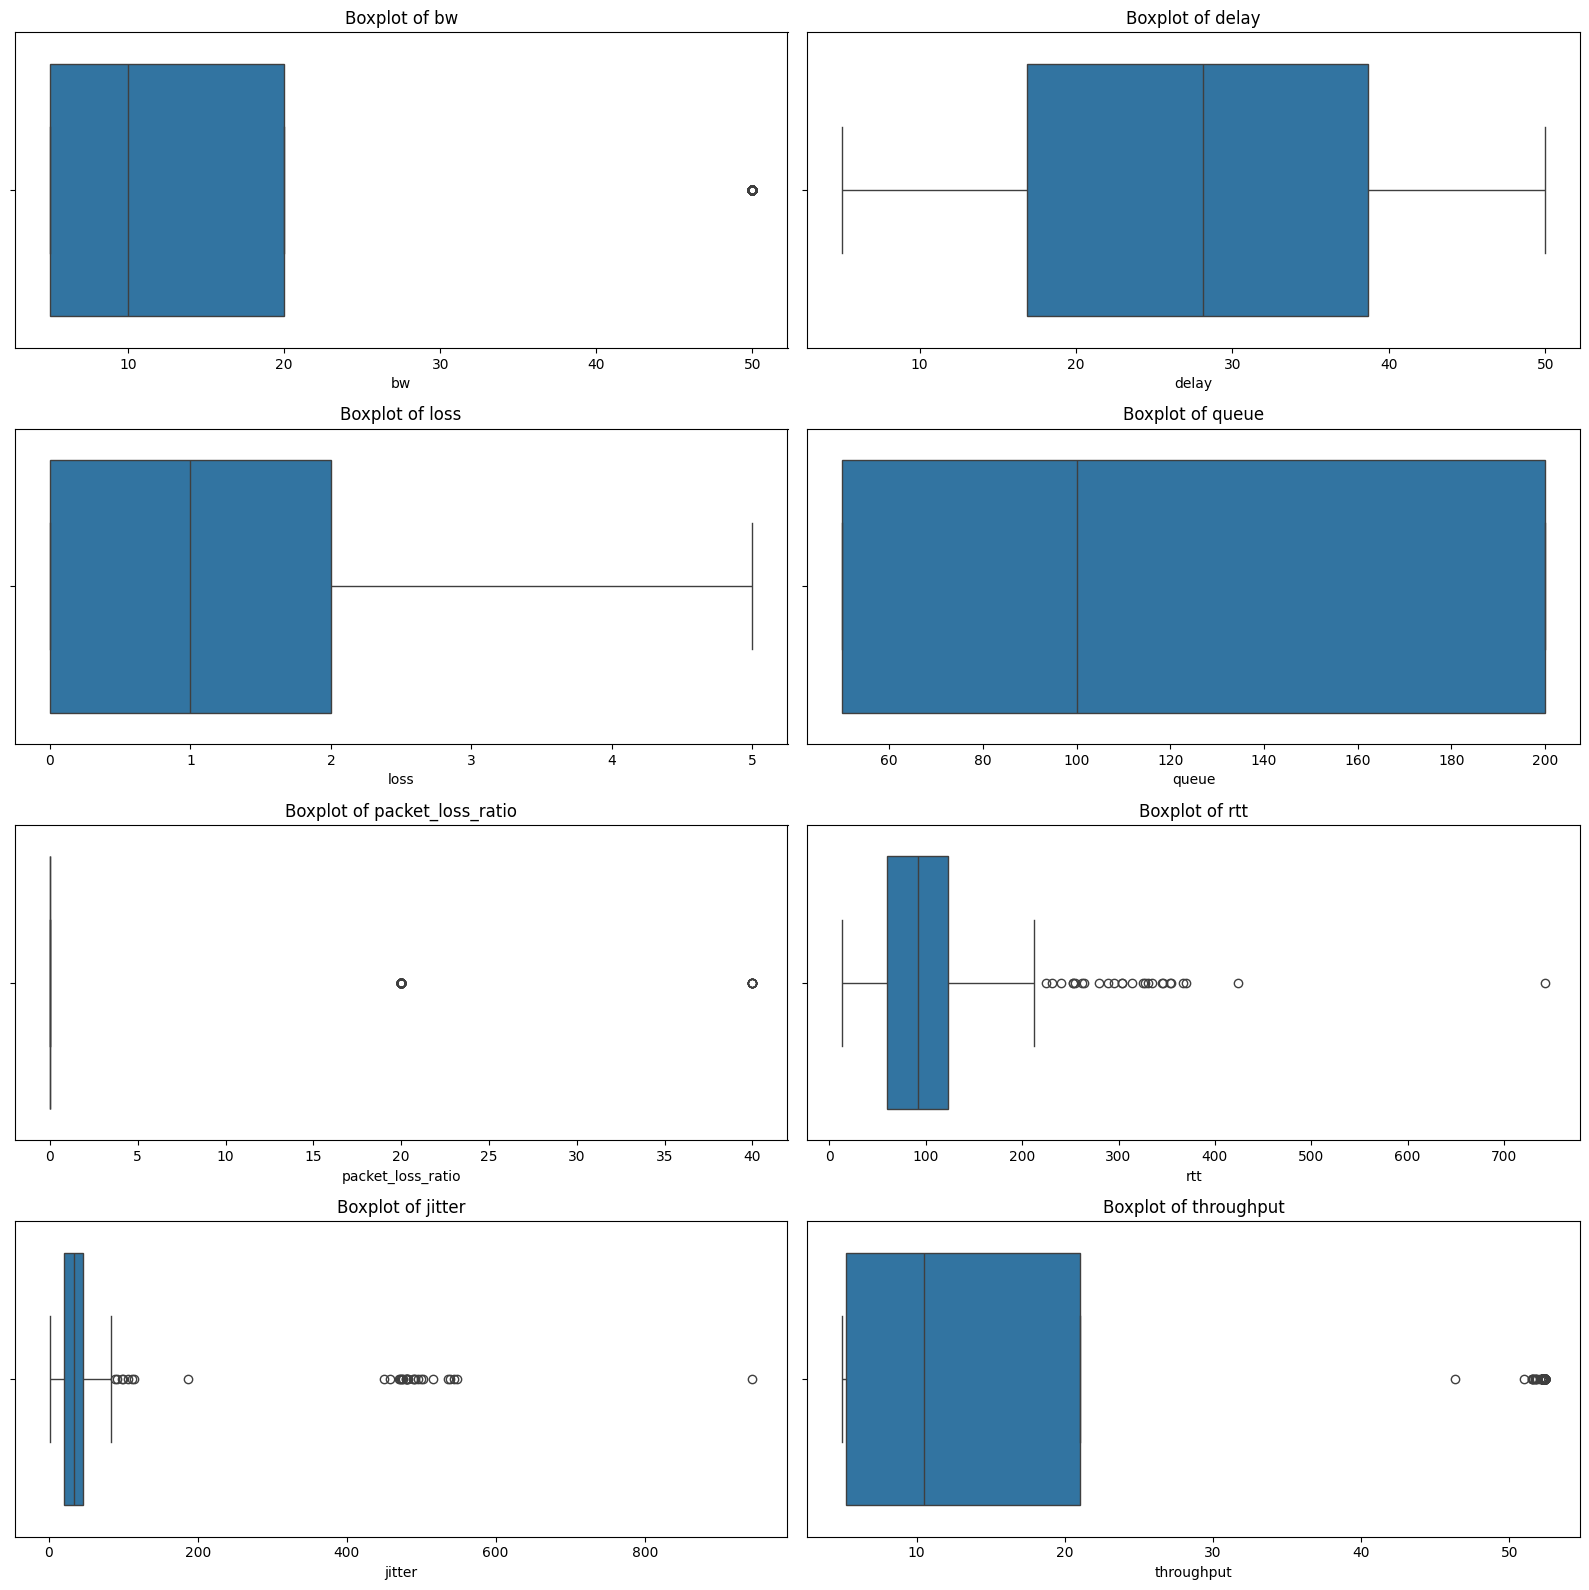

In [ ]:
numeric_cols = df.columns
rows = math.ceil(len(numeric_cols)/2)

plt.figure(figsize=(16, rows*4))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(rows, 2, i)
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot of {col}")

plt.tight_layout()
plt.show()

In [ ]:
def iqr_capping(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    df[column] = np.where(df[column] < lower_bound, lower_bound, df[column])
    df[column] = np.where(df[column] > upper_bound, upper_bound, df[column])
    return df

In [ ]:
columns_to_cap = ['bw', 'throughput']
for col in columns_to_cap:
    if col in df.columns:
        df = iqr_capping(df, col)
        print(f"'{col}' sütununda aykırı değerler IQR ile sınırlara çekildi.")

'bw' sütununda aykırı değerler IQR ile sınırlara çekildi.
'throughput' sütununda aykırı değerler IQR ile sınırlara çekildi.


In [ ]:
columns_to_transform = ['rtt', 'jitter']
for col in columns_to_transform:
    if col in df.columns:
        df[col] = np.log1p(df[col]) # Log dönüşümü uygulandı

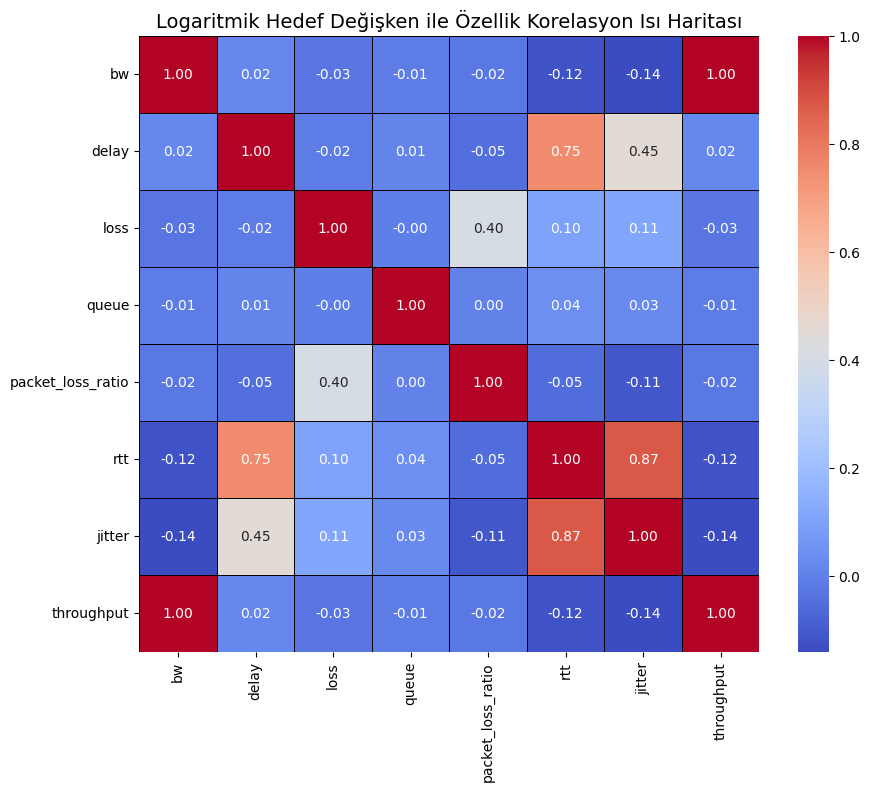

In [ ]:
correlation_matrix = df.corr()

# 2. Isı Haritasını Görselleştirme
plt.figure(figsize=(10, 8))
sns.heatmap(
    correlation_matrix,
    annot=True,
    fmt=".2f",
    cmap='coolwarm',
    cbar=True,
    linewidths=.5,
    linecolor='black'
)
plt.title('Logaritmik Hedef Değişken ile Özellik Korelasyon Isı Haritası', fontsize=14)
plt.show()

In [ ]:
TARGET_COLUMN = "rtt"
SELECTED_FEATURES = ["bw", "loss", "jitter", "throughput"]

In [ ]:
# Bağımlı Değişken (Y)
Y = df[TARGET_COLUMN]

# Bağımsız Değişkenler (X) - Sadece seçilen özellikleri içerir
X = df[SELECTED_FEATURES]

In [ ]:
# Standardizasyon Uygulama
scaler = StandardScaler()
X_scaled_array = scaler.fit_transform(X)
X_scaled = pd.DataFrame(X_scaled_array, columns=X.columns)
print("Seçilen özelliklere Standardizasyon uygulandı.")

Seçilen özelliklere Standardizasyon uygulandı.


In [ ]:
# Eğitim/Test Ayırma
X_train, X_test, Y_train, Y_test = train_test_split(
    X_scaled, Y, test_size=0.2, random_state=42
)

In [ ]:
# --- 1. Doğrusal Regresyon (Linear Regression) ---
lr_model = LinearRegression()
lr_model.fit(X_train, Y_train)
print("Doğrusal Regresyon Eğitimi Tamamlandı.")
models = {'Linear Regression': lr_model}

Doğrusal Regresyon Eğitimi Tamamlandı.


In [ ]:
# --- 2. K-En Yakın Komşu Regresyonu (KNN Regressor) ve Hiperparametre Optimizasyonu ---
knn_params = {'n_neighbors': [3, 5, 7, 9], 'weights': ['uniform', 'distance']}
knn_gs = GridSearchCV(
    estimator=KNeighborsRegressor(),
    param_grid=knn_params,
    scoring='neg_mean_squared_error',
    cv=3,
    verbose=0,
    n_jobs=-1
)
knn_gs.fit(X_train, Y_train)
knn_best_model = knn_gs.best_estimator_
models['KNN Regressor'] = knn_best_model
print(f"KNN Regresyon Eğitimi ve Optimizasyonu Tamamlandı. En iyi k: {knn_gs.best_params_['n_neighbors']}")

KNN Regresyon Eğitimi ve Optimizasyonu Tamamlandı. En iyi k: 5


In [ ]:
# --- 3. Destek Vektör Regresyonu (SVR) ---
svr_params = {
    'kernel': ['rbf'],
    'C': [0.1, 1, 10],
    'epsilon': [0.1, 0.2]
}
svr_gs = GridSearchCV(SVR(), param_grid=svr_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
svr_gs.fit(X_train, Y_train)
models['SVR Regressor'] = svr_gs.best_estimator_
print(f"SVR Regresyon Eğitimi Tamamlandı. En iyi C: {svr_gs.best_params_['C']}")

SVR Regresyon Eğitimi Tamamlandı. En iyi C: 1


In [ ]:
# --- 4. Decision Tree Regressor (Karar Ağacı) ---
dt_params = {'max_depth': [5, 10, 15], 'random_state': [42]} # Aşırı uydurmayı engellemek için derinlik optimize edilir
dt_gs = GridSearchCV(DecisionTreeRegressor(), param_grid=dt_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
dt_gs.fit(X_train, Y_train)
models['Decision Tree'] = dt_gs.best_estimator_
print(f"Karar Ağacı Eğitimi Tamamlandı. En iyi derinlik: {dt_gs.best_params_['max_depth']}")

Karar Ağacı Eğitimi Tamamlandı. En iyi derinlik: 5


In [ ]:
#  --- 5. Random Forest Regressor (Rastgele Orman) ---
rf_params = {
    'n_estimators': [50, 100],  # Kullanılacak ağaç sayısı
    'max_depth': [5, 10],       # Ağacın maksimum derinliği
    'random_state': [42]
}
rf_gs = GridSearchCV(RandomForestRegressor(), param_grid=rf_params, scoring='neg_mean_squared_error', cv=3, verbose=0, n_jobs=-1)
rf_gs.fit(X_train, Y_train)
models['Random Forest'] = rf_gs.best_estimator_
print(f"Random Forest Eğitimi ve Optimizasyonu Tamamlandı. En iyi derinlik: {rf_gs.best_params_['max_depth']}")

Random Forest Eğitimi ve Optimizasyonu Tamamlandı. En iyi derinlik: 5


In [ ]:
results_df = pd.DataFrame(columns=['MAE', 'RMSE', 'R2'])
predictions = {}

In [ ]:
for name, model in models.items():
    Y_pred = model.predict(X_test)
    predictions[name] = Y_pred

    mae = mean_absolute_error(Y_test, Y_pred)
    rmse = np.sqrt(mean_squared_error(Y_test, Y_pred))
    r2 = r2_score(Y_test, Y_pred)

    results_df.loc[name] = [mae, rmse, r2]

print("Modellerin Performans Metrikleri:")
print(results_df)

Modellerin Performans Metrikleri:
                        MAE      RMSE        R2
Linear Regression  0.198449  0.248088  0.792673
KNN Regressor      0.187482  0.246729  0.794939
Random Forest      0.165721  0.219015  0.838418
SVR Regressor      0.166812  0.224431  0.830329
Decision Tree      0.176134  0.228501  0.824118


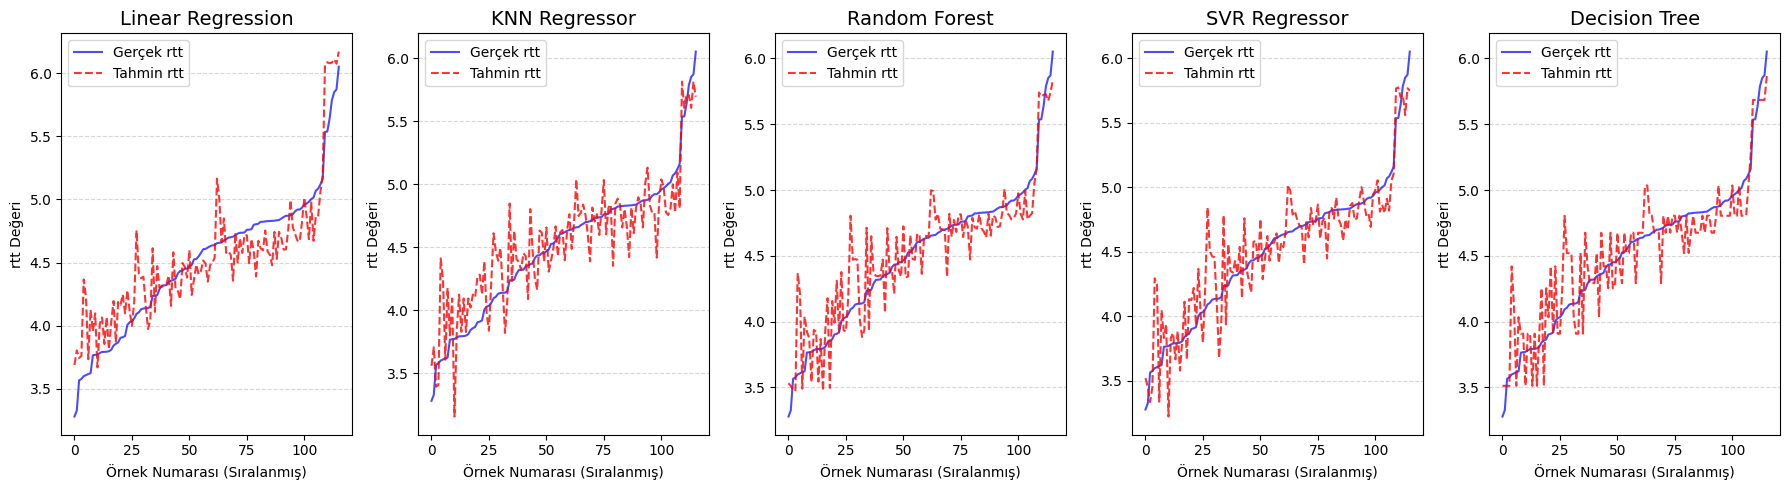

In [ ]:
plt.figure(figsize=(18, 5))
for i, (name, Y_pred) in enumerate(predictions.items()):
    plt.subplot(1, 5, i + 1)

    df_compare = pd.DataFrame({
        f'Gerçek ({TARGET_COLUMN})': Y_test,
        f'Tahmin ({TARGET_COLUMN})': Y_pred
    }).sort_values(by=f'Gerçek ({TARGET_COLUMN})').reset_index(drop=True)

    plt.plot(df_compare[f'Gerçek ({TARGET_COLUMN})'], label=f'Gerçek {TARGET_COLUMN}', color='blue', alpha=0.7)
    plt.plot(df_compare[f'Tahmin ({TARGET_COLUMN})'], label=f'Tahmin {TARGET_COLUMN}', color='red', linestyle='--', alpha=0.8)

    plt.title(f'{name}', fontsize=14)
    plt.xlabel('Örnek Numarası (Sıralanmış)')
    plt.ylabel(f'{TARGET_COLUMN} Değeri')
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

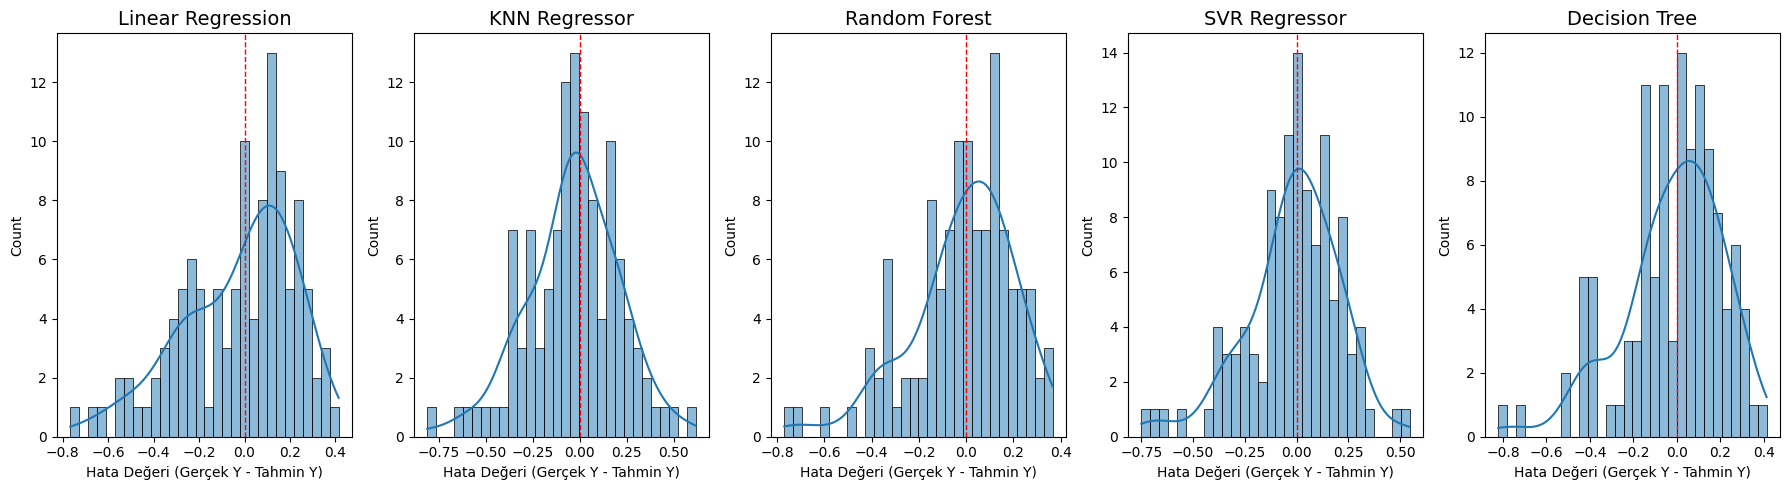

In [ ]:
plt.figure(figsize=(18, 5)) # Hata dağılımı için yeni ve geniş figür

for i, (name, Y_pred) in enumerate(predictions.items()):
    residuals = Y_test - Y_pred # Hata = Gerçek - Tahmin

    plt.subplot(1, 5, i + 1)
    sns.histplot(residuals, kde=True, bins=30)

    plt.title(f'{name}', fontsize=14)
    plt.xlabel('Hata Değeri (Gerçek Y - Tahmin Y)')
    plt.axvline(0, color='red', linestyle='--', linewidth=1) # Sıfır çizgisi

plt.tight_layout()
plt.show()